# SARIMAX

## 1. Sourcing and Loading

### Load relevant librarie

In [1]:
#File and name management libraries
import os
import shutil

#Math & data handling libraries
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

#dates and timeframe libraries
import datetime
import matplotlib.dates as mdates

### Load the data

In [2]:
#### Root directory ####

# Set root directory 
ROOT_DIR = os.path.normpath(os.getcwd() + os.sep + os.pardir)
print(ROOT_DIR)

D:\gitProjects\WTI_Crude_Oil_Price_Prediction_Using_ML


In [3]:
#### File directory ####

#Define file name and location
file_csv = 'step3_eda_wti_price.csv'
file_path = '\\data\\interim\\'

#Set file name and location
f = ROOT_DIR + file_path + file_csv
print(f)

D:\gitProjects\WTI_Crude_Oil_Price_Prediction_Using_ML\data\interim\step3_eda_wti_price.csv


## 2. Cleaning, transforming and visualizing

In [4]:
BASE_DATE = '2022-07-01'
TARGET_FEATURE = 'wti'

### Type conversions

In [5]:
#cast csv to dataframe
df = pd.read_csv(f)

#convert 'Date' column to date format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors="raise")

#set Date as index
df.set_index('Date', drop=True, inplace=True)


In [6]:
#print shape of dataframe
print('Shape:',df.shape)

#display df head
display(df[TARGET_FEATURE].head(10).round(2))

Shape: (280, 29)


Date
2000-01-01    27.26
2000-02-01    29.37
2000-03-01    29.84
2000-04-01    25.72
2000-05-01    28.79
2000-06-01    31.82
2000-07-01    29.70
2000-08-01    31.26
2000-09-01    33.88
2000-10-01    33.11
Name: wti, dtype: float64

In [7]:
# Define the BASE_DATE variable
BASE_DATE = pd.to_datetime(BASE_DATE)

### Making a predictor variable `y`

In [8]:
y = df[TARGET_FEATURE][:BASE_DATE]
type(y)

pandas.core.series.Series

### Getting summary statistics for `y`

In [9]:
y.describe().round(2)

count    271.00
mean      62.07
std       26.09
min       16.55
25%       40.86
50%       59.04
75%       82.10
max      133.88
Name: wti, dtype: float64

### Plot `y`

In [10]:
def plotter(y):
    fig, ax = plt.subplots(figsize=(9, 4))
    plt.plot(y.index, y)
    plt.show()

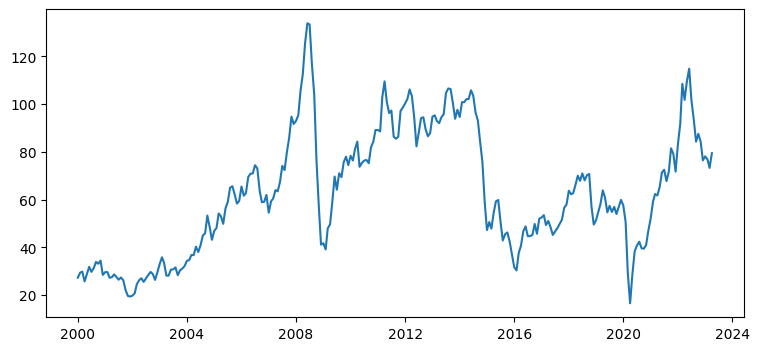

In [11]:
plotter(df[TARGET_FEATURE])

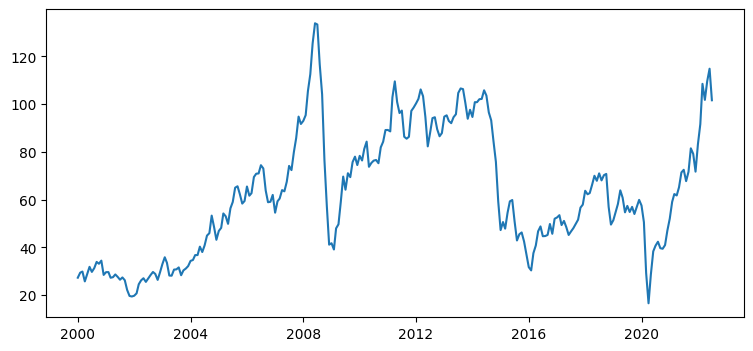

In [12]:
plotter(y)

## 3. Modeling

### Decomposition

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decomposition(time_series):
    # Perform seasonal decomposition
    decomposition = seasonal_decompose(time_series)

    # Extract the trend, seasonal, and residual components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot the original data, trend, seasonal, and residuals
    plt.figure(figsize=(9, 9))

    # Original data
    plt.subplot(411)
    plt.plot(time_series, label='Original Data')
    plt.legend(loc='best')

    # Trend component
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')

    # Seasonal component
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='best')

    # Residual component
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()


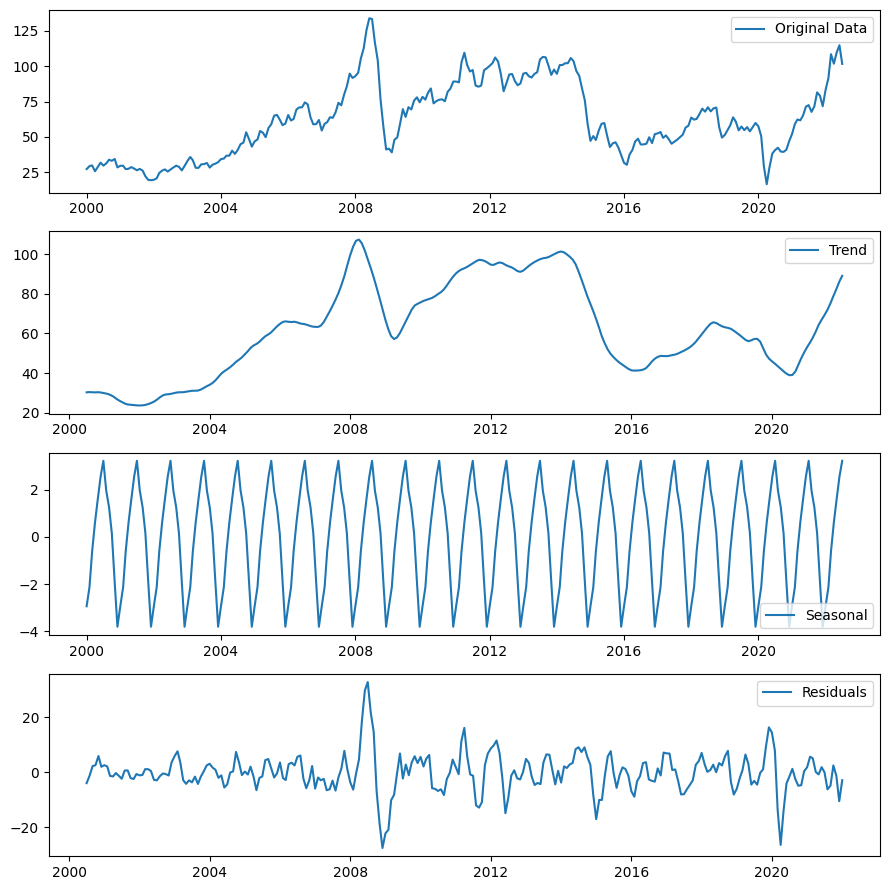

In [14]:
plot_seasonal_decomposition(y)

### Testing For Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(time_series, p_val):
    print('Augmented Dickey-Fuller Test')
    print('Hypotheses: H0 (non-stationary) | Ha (stationary)')
    print('---------------------------')
    
    result = adfuller(time_series)
    labels = ['ADF Statistic', 'p-value', 'Number of Lags', 'Number of Observations']
    
    for value, label in zip(result, labels):
        print(label + ': ' + str(value))
        
    print('---------------------------')    
    if result[1] <= p_val:
        print("Conclusion: Strong evidence against the null hypothesis (H0).")
        print("Reject the null hypothesis. The data has no unit root and is stationary.")
    else:
        print("Conclusion: Weak evidence against the null hypothesis.")
        print("The time series has a unit root, indicating it is non-stationary.")

In [16]:
adfuller_test(y, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -2.6710421335054995
p-value: 0.07918468272032503
Number of Lags: 1
Number of Observations: 269
---------------------------
Conclusion: Weak evidence against the null hypothesis.
The time series has a unit root, indicating it is non-stationary.


In [17]:
y_diff = y.diff().dropna()

In [18]:
y_diff.describe().round(2)

count    270.00
mean       0.28
std        5.81
min      -27.51
25%       -2.52
50%        1.03
75%        3.46
max       16.86
Name: wti, dtype: float64

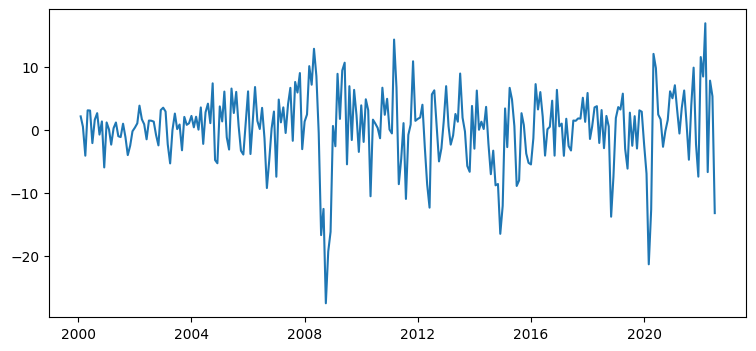

In [19]:
plotter(y_diff)

In [20]:
adfuller_test(y_diff, 0.05)

Augmented Dickey-Fuller Test
Hypotheses: H0 (non-stationary) | Ha (stationary)
---------------------------
ADF Statistic: -11.284095277409605
p-value: 1.4322240615736097e-20
Number of Lags: 0
Number of Observations: 269
---------------------------
Conclusion: Strong evidence against the null hypothesis (H0).
Reject the null hypothesis. The data has no unit root and is stationary.


### ACF & PACF Plots

In [21]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_acf_pacf(time_series, max_lags=50):
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    
    # Plot the ACF
    plot_acf(time_series, lags=max_lags, ax=axes[0])
    axes[0].set_title('Autocorrelation Function (ACF)')
    
    # Plot the PACF
    plot_pacf(time_series, lags=max_lags, ax=axes[1])
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    
    plt.tight_layout()
    plt.show()

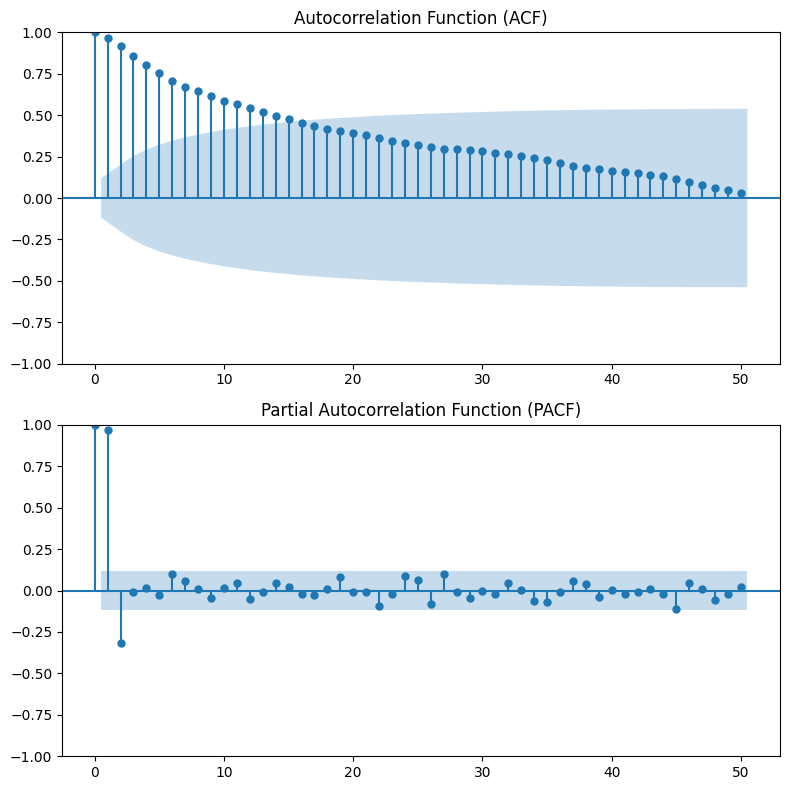

In [22]:
plot_acf_pacf(y,50)

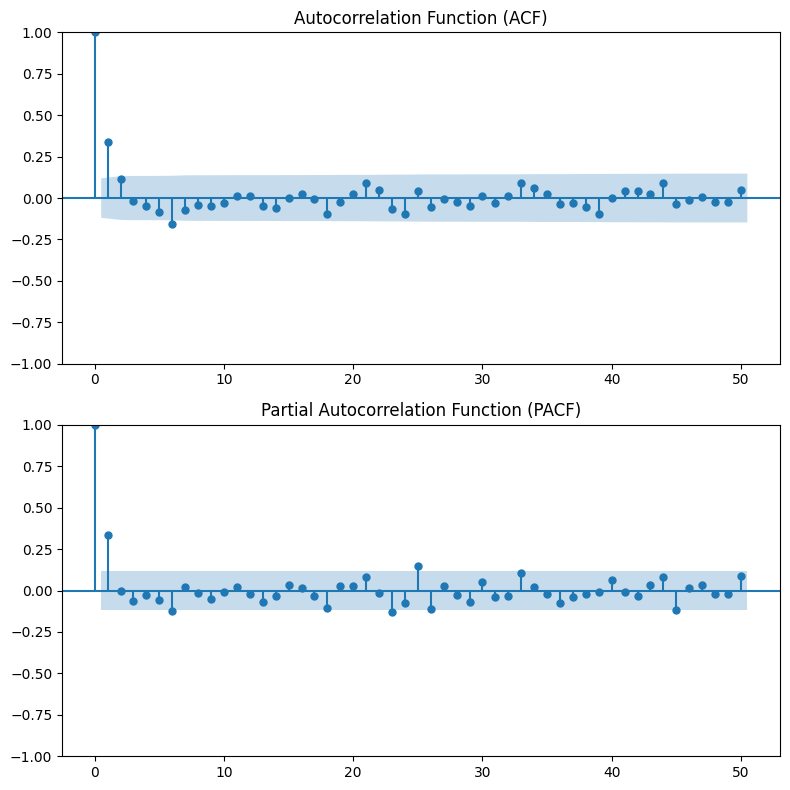

In [23]:
plot_acf_pacf(y_diff,50)

### The SARIMA model


In [24]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [25]:
def find_best_sarimax_params(data, max_ar=2, max_ma=2, max_s=2):
    p = d = q = range(0, max_ar) 
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = SARIMAX(data,
                                order=param,
                                seasonal_order=param_seasonal,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
                results = model.fit()

                if results.aic < best_aic:
                    best_aic = results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
            except:
                continue

    return best_pdq, best_seasonal_pdq


### Find the best SARIMA params

In [26]:
best_params = find_best_sarimax_params(y)
print('Best ARIMA params:', best_params[0])
print('Best seasonal params:', best_params[1])

Best ARIMA params: (1, 1, 1)
Best seasonal params: (0, 1, 1, 12)


### Fit SARIMA model

In [27]:
# specify the model
model = SARIMAX(y,
                order=best_params[0],              # specify your ARIMA order
                seasonal_order=best_params[1], # specify your seasonal order
                enforce_stationarity=False,   # depending on your data you might want to change these
                enforce_invertibility=False)

# fit the model
results = model.fit()

# get a summary of the model parameters and performance
print(results.summary())

# make predictions
pred = results.get_prediction(start=pd.to_datetime('2023-01-01'), dynamic=False)
pred_conf = pred.conf_int()

                                     SARIMAX Results                                      
Dep. Variable:                                wti   No. Observations:                  271
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -780.111
Date:                            Tue, 18 Jul 2023   AIC                           1568.221
Time:                                    00:34:39   BIC                           1582.210
Sample:                                01-01-2000   HQIC                          1573.855
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3221      0.131      2.455      0.014       0.065       0.579
ma.L1          0.0161      0.161   

## 4. Forecast

In [32]:

def plot_forecast(model_results, data, data_all, steps=6, start_date=None):
    # forecast for the next 'steps' periods
    forecast = model_results.get_forecast(steps=steps)
    forecast_ci = forecast.conf_int()

    # If a start date is provided, slice the data
    if start_date:
        data = data[start_date:]
        data_all = data_all[start_date:]

    # create a new row for the forecast confidence interval dataframe
    new_row = pd.DataFrame([[data.values[-1], data.values[-1]]], columns=forecast_ci.columns, index=[pd.to_datetime(data.index[-1])])

    # concatenate the new row and the original dataframe
    forecast_ci = pd.concat([new_row, forecast_ci])

    # set seaborn style
    sns.set(style='whitegrid')

    # set the figure size
    plt.figure(figsize=(16, 6))

    # plot the time series data
    sns.lineplot(data=data, color='k', label='Historical')
    sns.lineplot(data=data_all[BASE_DATE:], color='k', linestyle = 'dotted', label='Actual')


    forecast_index = pd.DatetimeIndex([data.index[-1]]).append(forecast.predicted_mean.index)
    forecast_values = np.append(np.array(data.values[-1]), forecast.predicted_mean.values)

    # plot your mean predictions
    sns.lineplot(x=forecast_index, y=forecast_values, color='b', label='Forecast')

    # shade the area between your confidence limits
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 0], color='r', alpha=0.1)
    sns.lineplot(x=forecast_ci.index, y=forecast_ci.iloc[:, 1], color='r', alpha=0.1)
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='b', alpha=0.1)

    plt.title('SARIMA model forecast for next {} periods'.format(steps))
    plt.xlabel('Date')
    plt.ylabel('Values')
    
    plt.axvline(x=BASE_DATE, c='gray', linewidth = 2.5, ls='--', alpha=0.8)

    plt.legend()
    plt.show()


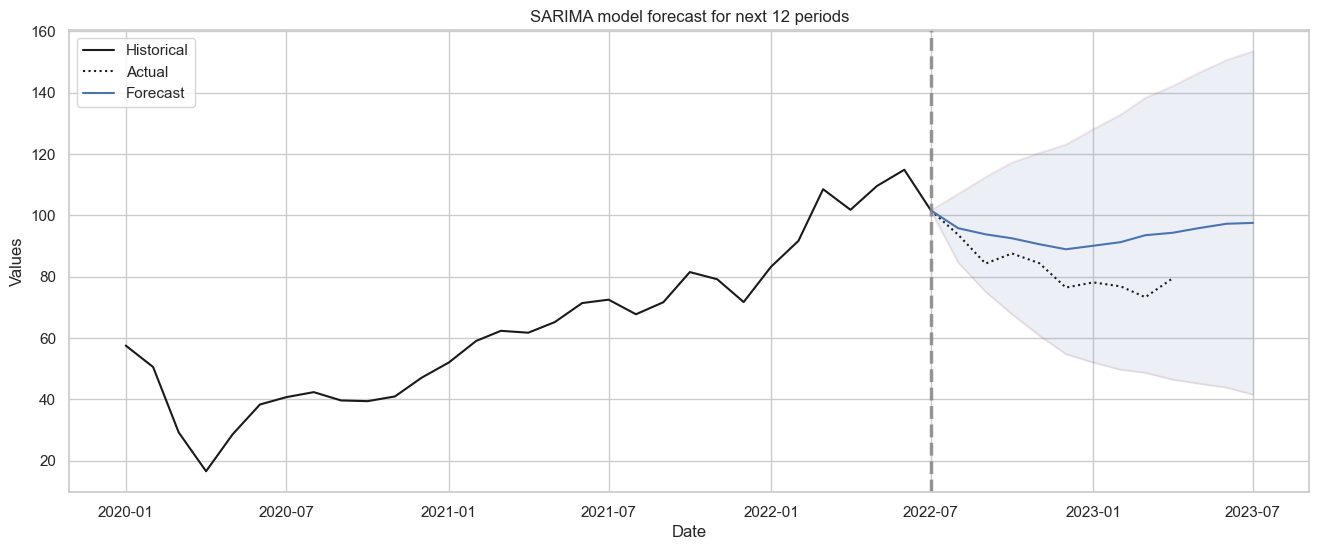

In [33]:
plot_forecast(results, y, df[TARGET_FEATURE],  12,'2020-01-01')